In [4]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:

DATASET_PATH = "C:/Users/lenovo/OneDrive/Desktop/audio-deepfake-detection-main/bhavesh/LA/ASVspoof2019_LA_train/flac"

LABEL_FILE_PATH = "C:/Users/lenovo/OneDrive/Desktop/audio-deepfake-detection-main/bhavesh/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  
SAMPLE_RATE = 16000  
DURATION = 5  
N_MELS = 128  

In [ ]:
labels = {}

with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")
    
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
  
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]

    X.append(mel_spectrogram)
    y.append(label)

In [14]:
X = np.array(X)
y = np.array(y)

X,y

(array([[[-77.99522 , -80.      , -80.      , ..., -80.      ,
          -80.      , -78.569336],
         [-70.491844, -76.31891 , -80.      , ..., -80.      ,
          -80.      , -76.42357 ],
         [-59.412792, -59.225166, -62.864876, ..., -64.179985,
          -64.98839 , -67.191246],
         ...,
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-80.      , -80.      , -80.      , ..., -80.      ,
          -80.      , -80.      ]],
 
        [[-67.49097 , -73.61943 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-65.48586 , -71.42825 , -80.      , ..., -80.      ,
          -80.      , -80.      ],
         [-61.25968 , -60.12696 , -60.503258, ..., -66.97652 ,
          -61.73862 , -61.109512],
         ...,
         [-80.      , -80.      , -80.      , ..., -69.02563 ,
          -69.15695 , -7

In [15]:
y_encoded = to_categorical(y, NUM_CLASSES)

In [16]:
split_index = int(0.8 * len(X))
X_train, X_val = X[:split_index], X[split_index:]
y_train, y_val = y_encoded[:split_index], y_encoded[split_index:]

In [ ]:

input_shape = (N_MELS, X_train.shape[2], 1)
model_input = Input(shape=input_shape)

In [18]:
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(model_input)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
model_output = Dense(NUM_CLASSES, activation='softmax')(x)

In [19]:
model = Model(inputs=model_input, outputs=model_output)

In [20]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.8790 - loss: 1.8200 - val_accuracy: 0.5636 - val_loss: 0.7450
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 56s 88ms/step - accuracy: 0.9526 - loss: 0.1169 - val_accuracy: 0.2319 - val_loss: 2.7424
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 57s 89ms/step - accuracy: 0.9760 - loss: 0.0680 - val_accuracy: 0.4789 - val_loss: 1.4031
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - accuracy: 0.9593 - loss: 0.1079 - val_accuracy: 0.3540 - val_loss: 2.2234
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 3635s 6s/step - accuracy: 0.9857 - loss: 0.0372 - val_accuracy: 0.3938 - val_loss: 2.3934
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 56s 89ms/step - accuracy: 0.9909 - loss: 0.0289 - val_accuracy: 0.2764 - val_loss: 4.4467
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 58s 91ms/step - accuracy: 0.9926 - loss: 0.0253 - val_accuracy: 0.2908 - val_loss: 3.8226
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 59s 92ms/step - accuracy: 0.9934 - loss: 0.0209 - 

In [ ]:

model.save("audio_classifier.h5")

--------
## Visualisation

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
# Load the model and preprocess test data (similar to training data preprocessing)
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import load_model

In [27]:
# Define paths and parameters
TEST_DATASET_PATH = "./TestEvaluation"
MODEL_PATH = "audio_classifier.h5"  # Replace with the actual path to your saved model
SAMPLE_RATE = 16000
DURATION = 5
N_MELS = 128
MAX_TIME_STEPS = 109

In [28]:
# Load the saved model
model = load_model(MODEL_PATH)

In [29]:
# Load and preprocess test data using librosa
X_test = []

test_files = os.listdir(TEST_DATASET_PATH)
for file_name in test_files:
    file_path = os.path.join(TEST_DATASET_PATH, file_name)

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract Mel spectrogram using librosa
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Ensure all spectrograms have the same width (time steps)
    if mel_spectrogram.shape[1] < MAX_TIME_STEPS:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, MAX_TIME_STEPS - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :MAX_TIME_STEPS]

    X_test.append(mel_spectrogram)

# Convert list to numpy array
X_test = np.array(X_test)

# Predict using the loaded model
y_pred = model.predict(X_test)

# Convert probabilities to predicted classes
y_pred_classes = np.argmax(y_pred, axis=1)

y_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[8.78250301e-01, 1.21749692e-01],
       [1.00000000e+00, 6.57171116e-23],
       [1.48176868e-02, 9.85182345e-01],
       [4.36989833e-10, 1.00000000e+00],
       [1.00000000e+00, 7.11314074e-09],
       [9.99999881e-01, 1.14120425e-07],
       [4.35295738e-02, 9.56470430e-01],
       [3.88960461e-06, 9.99996066e-01],
       [5.81168711e-01, 4.18831319e-01],
       [9.99932766e-01, 6.71841772e-05]], dtype=float32)

In [34]:
# Get True Labels

# Path to the ASVspoof 2019 protocol file
PROTOCOL_FILE_PATH = "C:/Users/lenovo/OneDrive/Desktop/audio-deepfake-detection-main/bhavesh/test_eval.txt"

# Dictionary to store true labels for each file
true_labels = {}

# Read the protocol file
with open(PROTOCOL_FILE_PATH, 'rb') as protocol_file:
    lines = protocol_file.read().decode('utf-8').splitlines()
    print(lines)

for line in lines:
    line = line.strip()  # Strip leading/trailing whitespace
    parts = line.split()
    if len(parts) > 1:  # Check if line has enough parts to extract label
        file_name = parts[0]
        label = parts[-1]  # Last part contains the label
        true_labels[file_name] = label

# Now 'true_labels' contains the true labels for each file
true_labels

['LA_0044 LA_E_1000147 - A10 spoof', 'LA_0067 LA_E_2267312 - - bonafide', 'LA_0020 LA_E_1007069 - A09 spoof', 'LA_0047 LA_E_9521934 - A16 spoof', 'LA_0018 LA_E_5169845 - - bonafide', 'LA_0032 LA_E_2601971 - A16 spoof', 'LA_0042 LA_E_4785445 - - bonafide', 'LA_0006 LA_E_4065507 - A11 spoof', 'LA_0013 LA_E_1644479 - A19 spoof', 'LA_0048 LA_E_4453325 - A17 spoof']


{'LA_0044': 'spoof',
 'LA_0067': 'bonafide',
 'LA_0020': 'spoof',
 'LA_0047': 'spoof',
 'LA_0018': 'bonafide',
 'LA_0032': 'spoof',
 'LA_0042': 'bonafide',
 'LA_0006': 'spoof',
 'LA_0013': 'spoof',
 'LA_0048': 'spoof'}

In [35]:
y_true = np.array([1 if label == "bonafide" else 0 for label in true_labels.values()]) # y_true are the true labels for each file
y_true

array([0, 1, 0, 0, 1, 0, 1, 0, 0, 0])

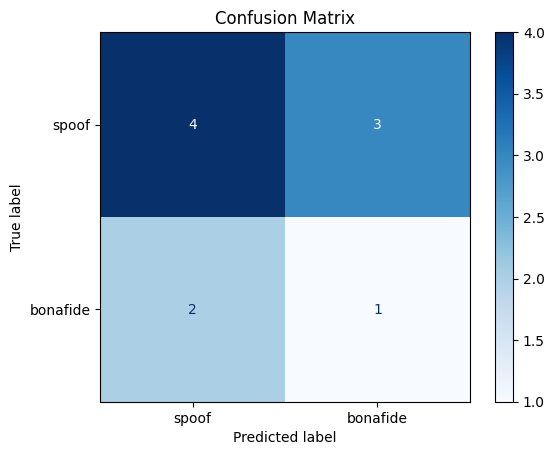

In [36]:
# CONFUSION MATRIX

cm = confusion_matrix(y_true, y_pred_classes)

# Display the confusion matrix
classes = ["spoof", "bonafide"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


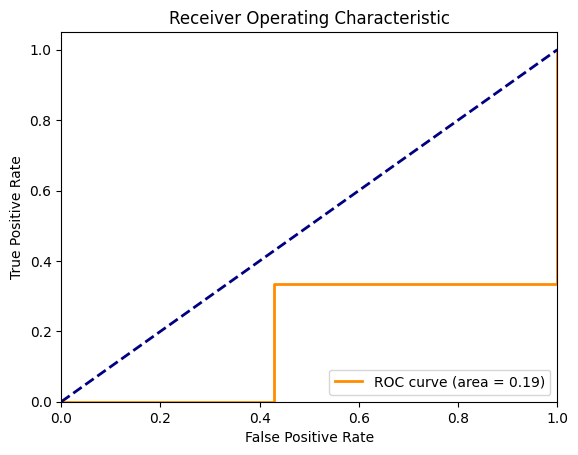

In [37]:
# ROC Curve

from sklearn.metrics import roc_curve, auc

# Predict using the loaded model
y_pred = model.predict(X_test)

# Get the predicted probabilities for the positive class
y_pred_prob = y_pred[:, 1]

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:

from sklearn.metrics import precision_recall_curve, average_precision_score

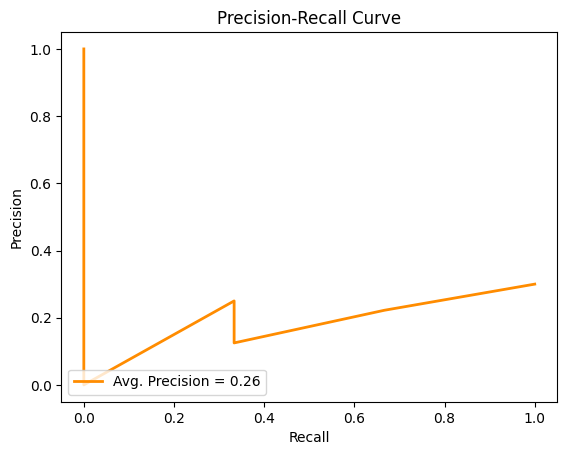

In [ ]:

precision, recall, _ = precision_recall_curve(y_true, y_pred_prob)
avg_precision = average_precision_score(y_true, y_pred_prob)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='darkorange', lw=2, label='Avg. Precision = %0.2f' % avg_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

In [ ]:
from sklearn.calibration import calibration_curve

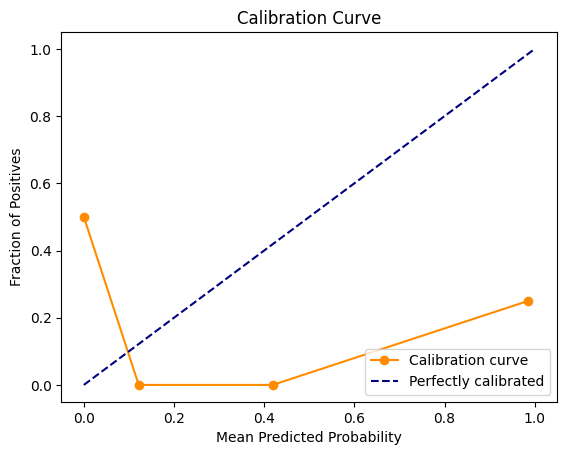

In [ ]:

prob_true, prob_pred = calibration_curve(y_true, y_pred_prob, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o', label='Calibration curve', color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='navy', label='Perfectly calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve')
plt.legend(loc="lower right")
plt.show()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_796\801023646.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_true, palette="Set2")


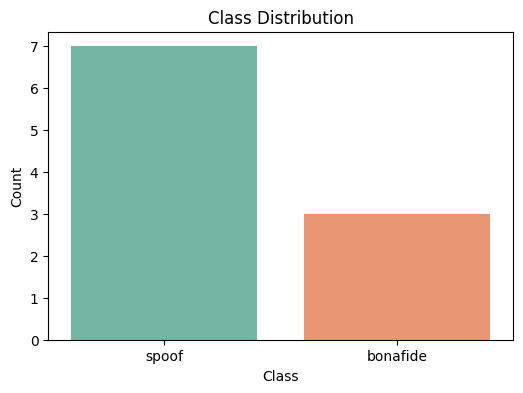

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt


LABELS = ['spoof', 'bonafide']

plt.figure(figsize=(6, 4))
sns.countplot(x=y_true, palette="Set2")
plt.xticks(ticks=[0, 1], labels=LABELS)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

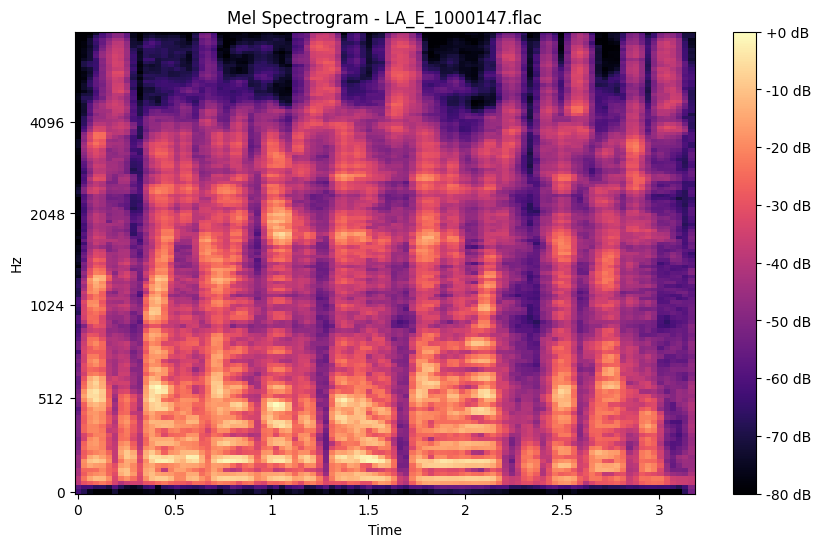

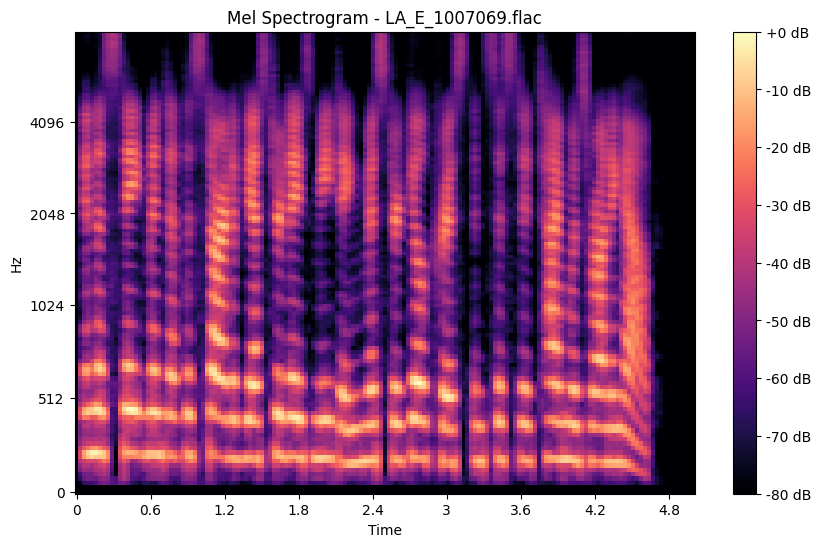

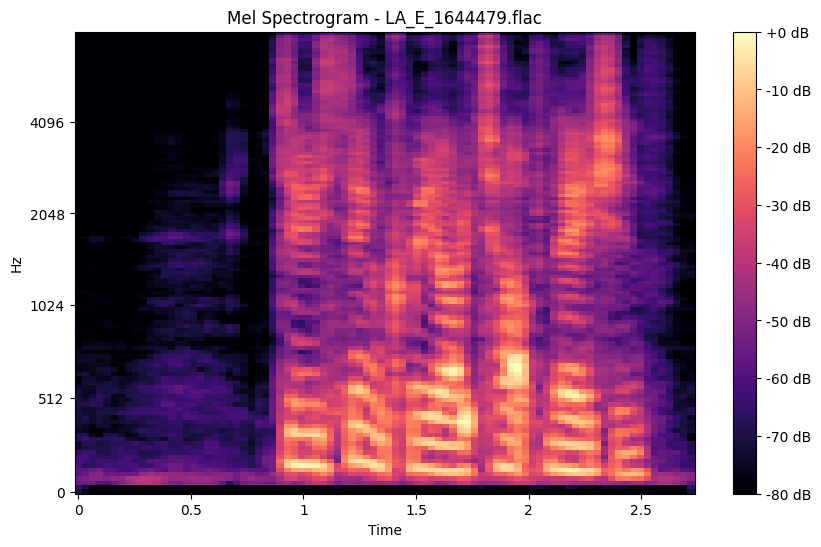

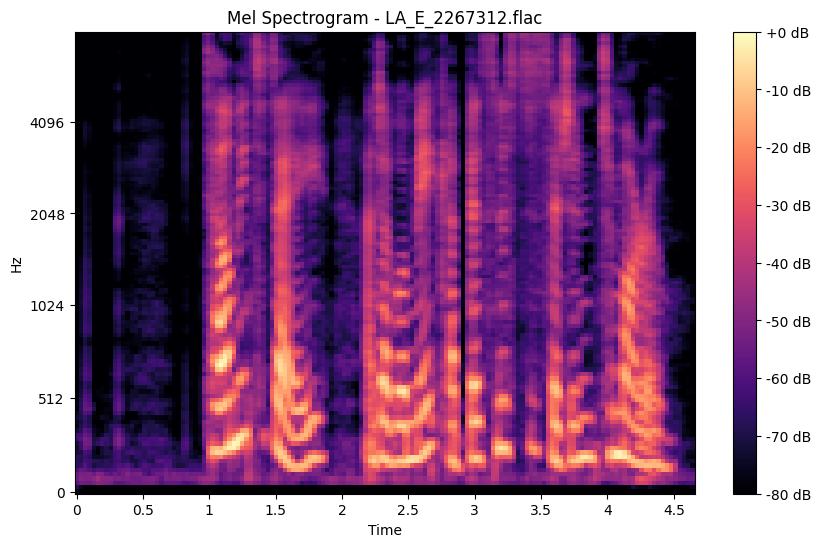

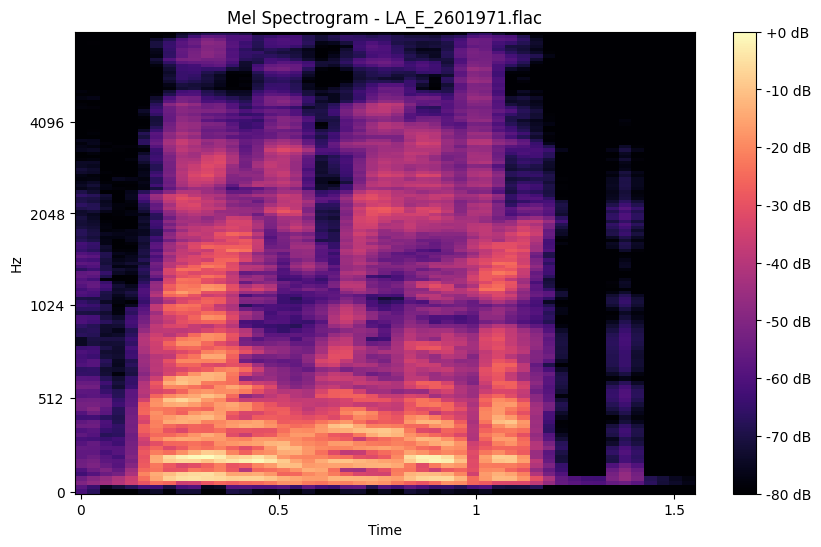

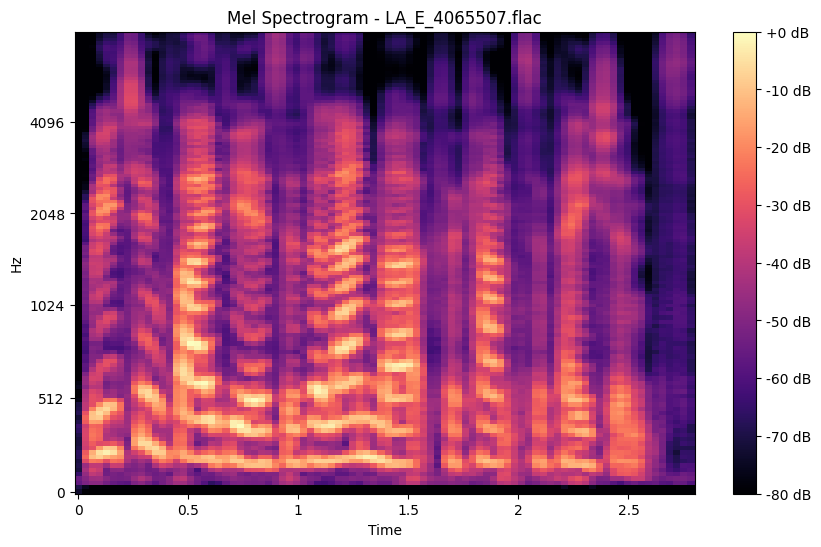

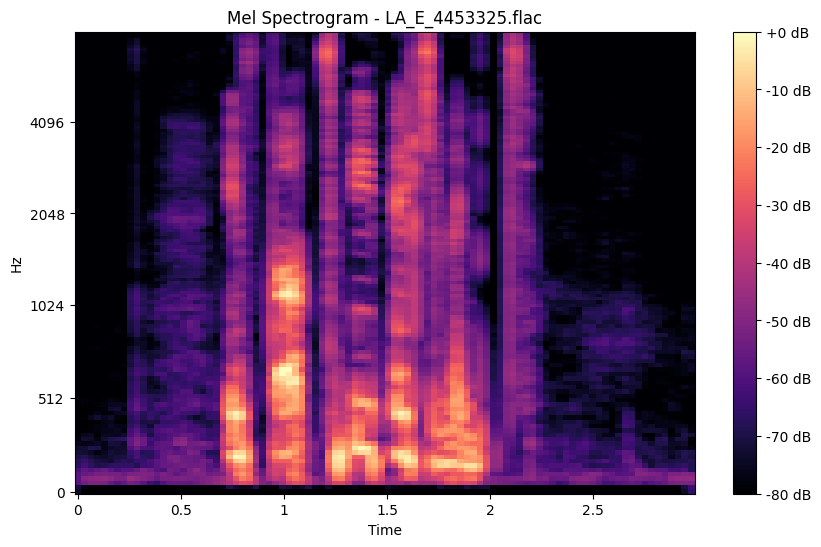

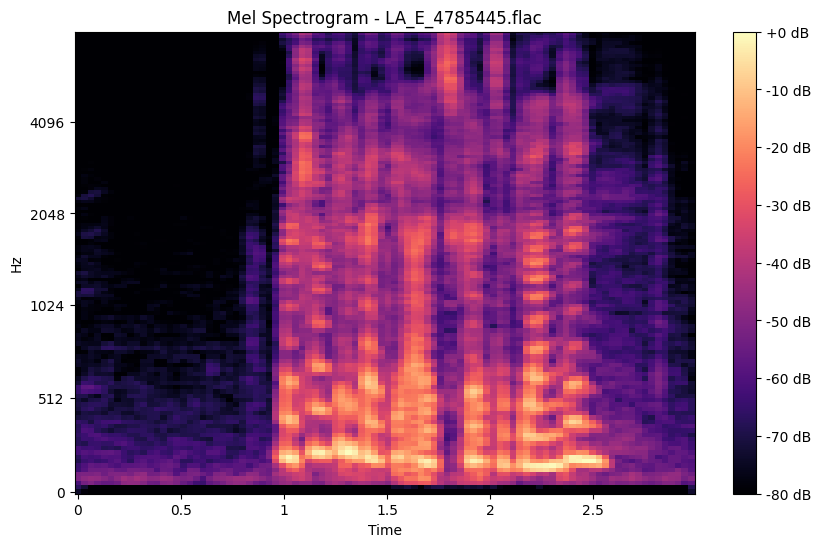

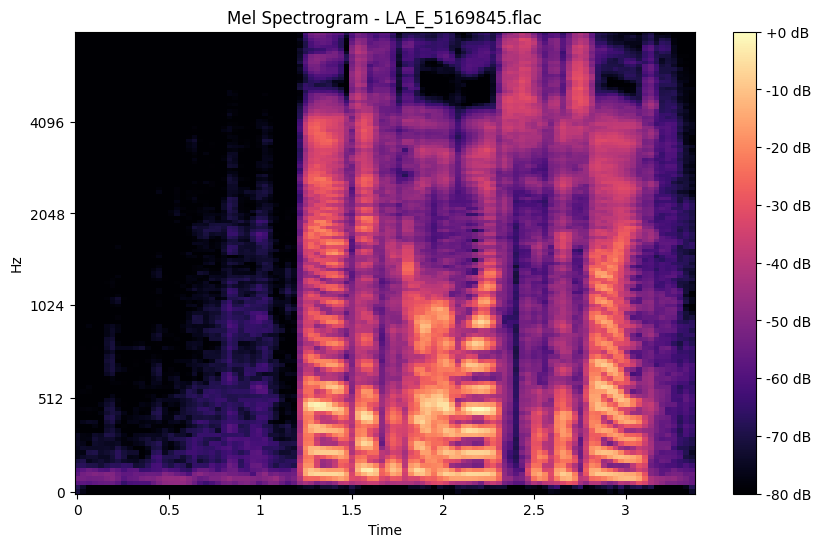

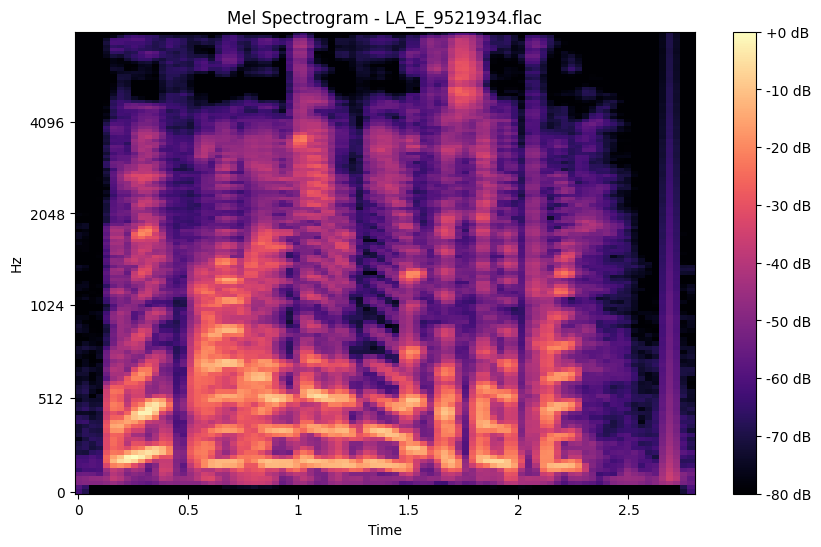

In [ ]:


import os
import librosa.display


folder_path = "TestEvaluation"

flac_files = [file for file in os.listdir(folder_path) if file.endswith(".flac")]


HOP_LENGTH = 512  

for flac_file in flac_files:
    audio_file_path = os.path.join(folder_path, flac_file)

    
    audio, _ = librosa.load(audio_file_path, sr=SAMPLE_RATE, duration=DURATION)


    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mel_spectrogram, x_axis='time', y_axis='mel', sr=SAMPLE_RATE, hop_length=HOP_LENGTH)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel Spectrogram - {flac_file}')
    plt.show()


In [ ]:
# !pip install graphviz pydot


   -------------------- ------------------- 1/2 [graphviz]
   -------------------- ------------------- 1/2 [graphviz]
   -------------------- ------------------- 1/2 [graphviz]
   -------------------- ------------------- 1/2 [graphviz]
   ---------------------------------------- 2/2 [graphviz]



In [ ]:
# from keras.utils import plot_model
# import tensorflow as tf

In [51]:
# # mod = tf.keras.saving.load_model("C:/Users/lenovo/OneDrive/Desktop/audio-deepfake-detection-main/bhavesh/audio_classifier.h5")
# from tensorflow.keras.models import load_model
# model = load_model("C:/Users/lenovo/OneDrive/Desktop/audio-deepfake-detection-main/bhavesh/audio_classifier.h5")

# plot_model(mod, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)